In [34]:
import sys
import os
import pandas as pd
from service.pipeline import (
    merge_dataframes, 
    dataframe_o3, 
    dataframe_gc, 
    PROCESSED_DATA_PATH, 
    parallel_process_texts, 
    ClassifierType, 
    get_model,
    logger
)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [35]:
# Unione dei dati
merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']


Statistiche descrittive per categoria:
categoria
Segreteria    1108
Didattica     1100
Tecnico       1088
Accesso       1023
Profilo       1000
dtype: int64

Percentuali per categoria:
categoria
Segreteria    20.83
Didattica     20.68
Tecnico       20.45
Accesso       19.23
Profilo       18.80
Name: proportion, dtype: float64


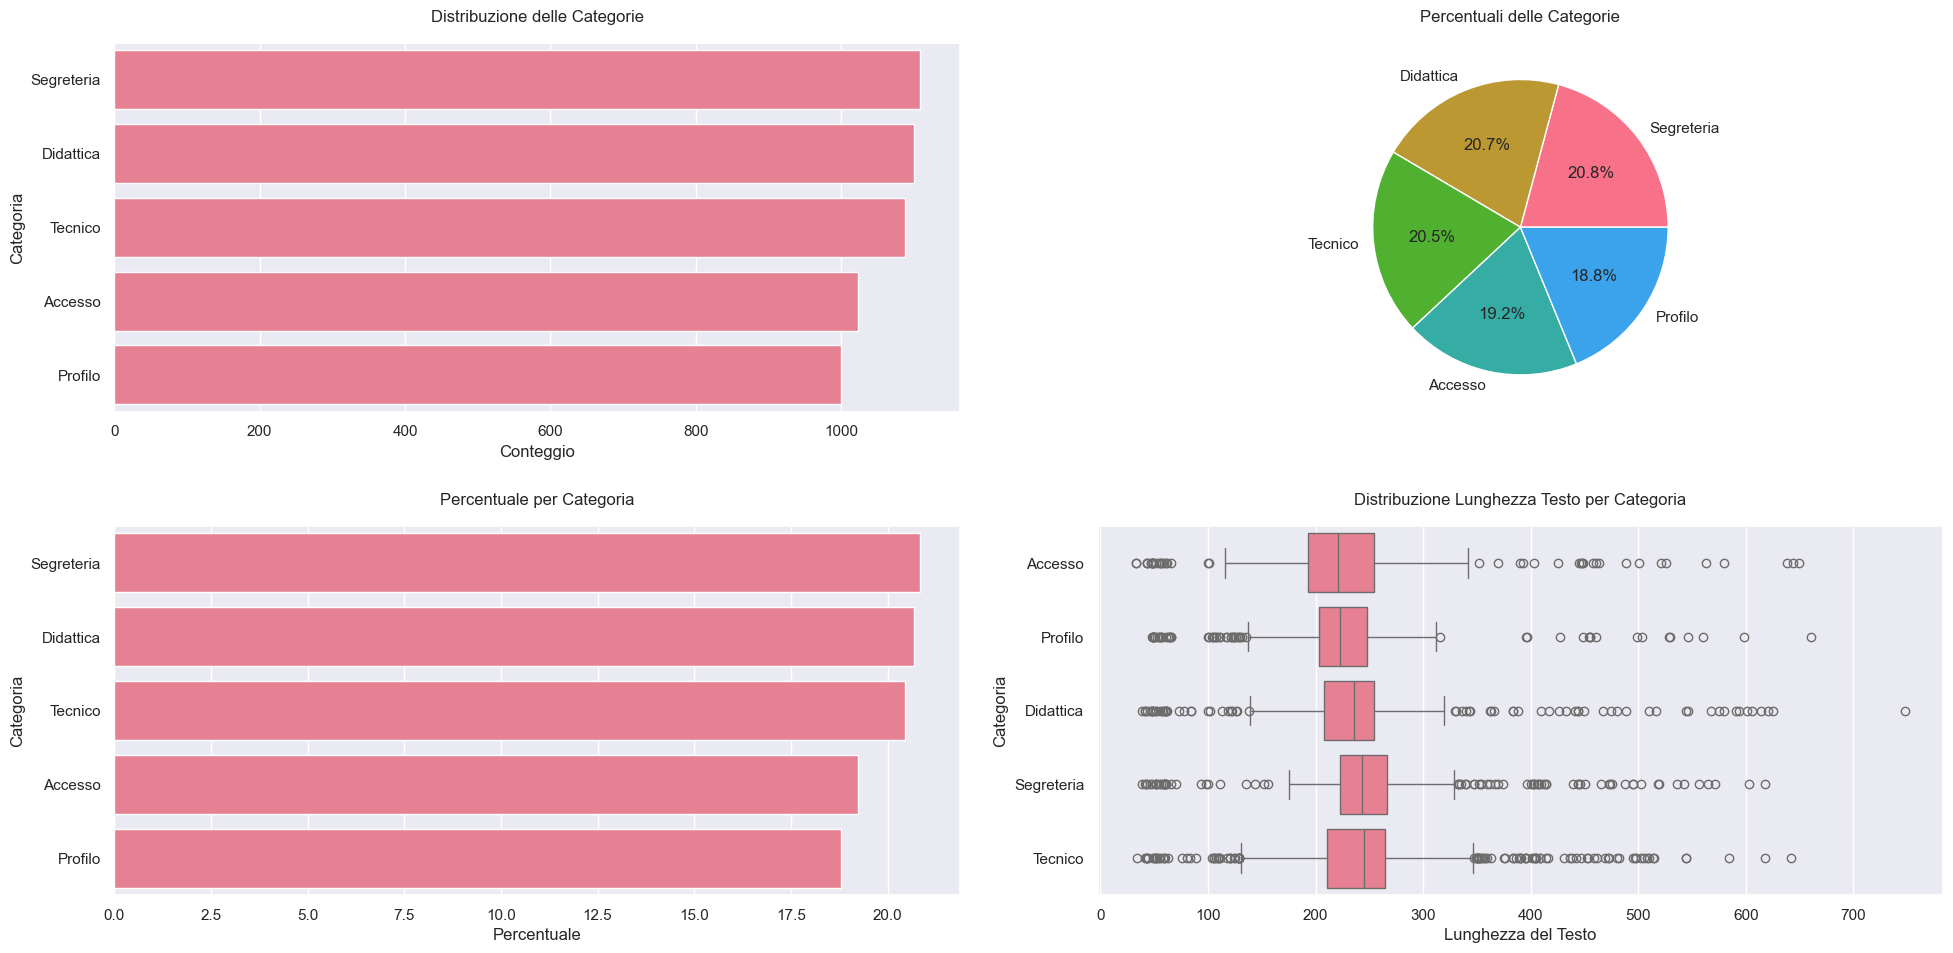

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

In [37]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    logger.info("Loading preprocessed data from '%s'...", PROCESSED_DATA_PATH)
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    logger.info("Preprocessed data not found, starting parallel preprocessing...")
    X_processed = parallel_process_texts(X, n_jobs=-1)
    logger.info("Saving preprocessed data to: %s", PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    logger.info("Preprocessing complete and cached.")

## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`.

In [38]:
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

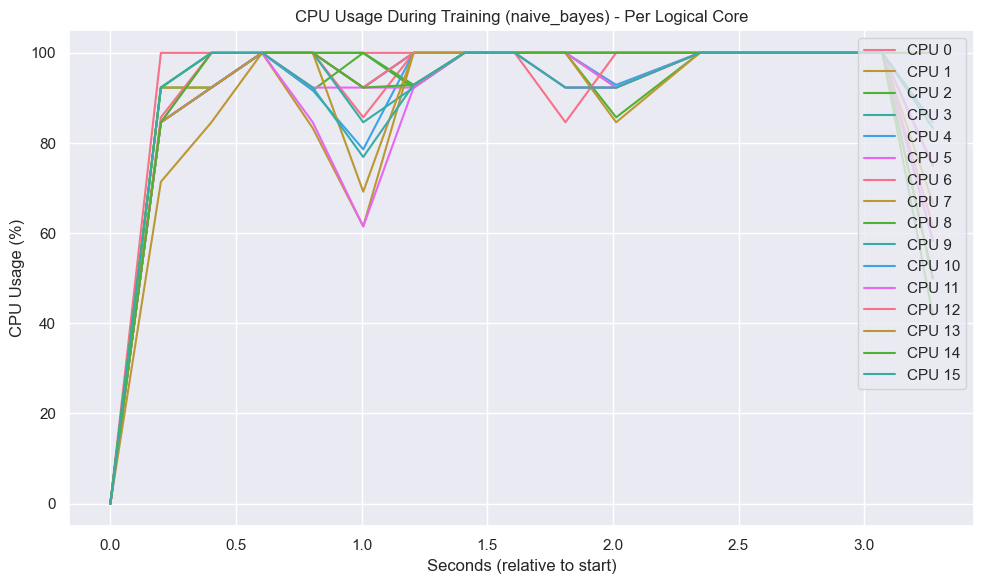

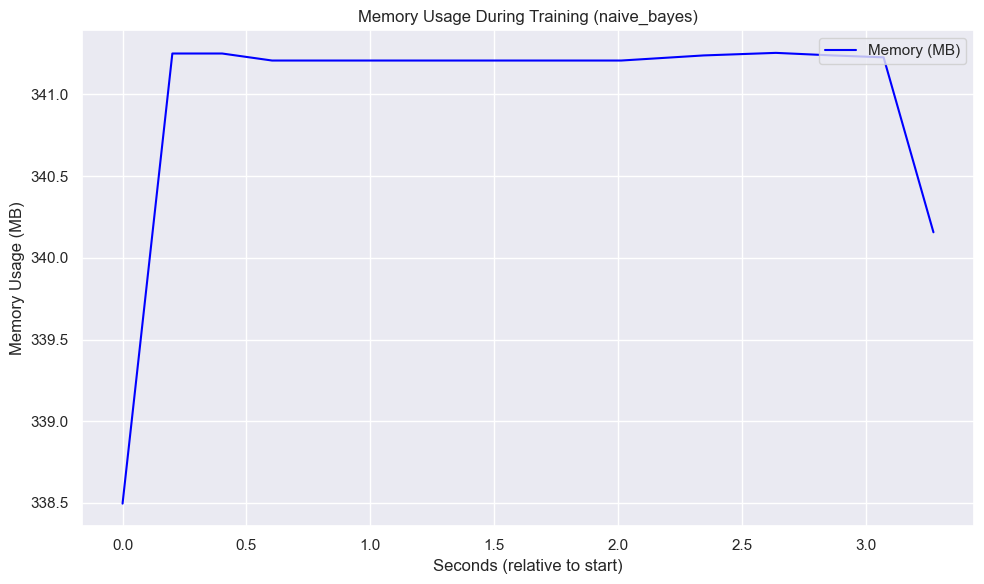

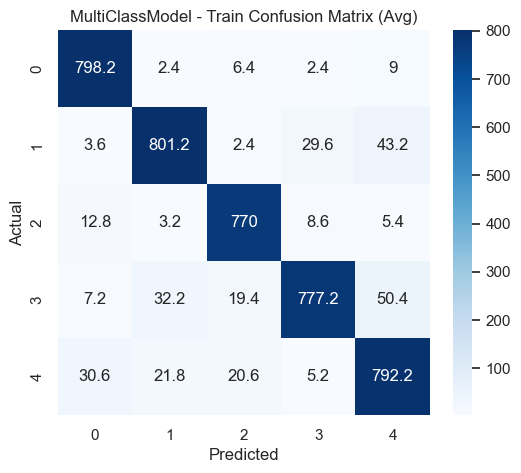

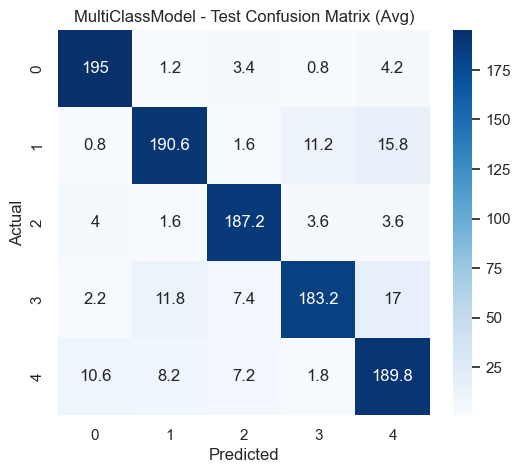

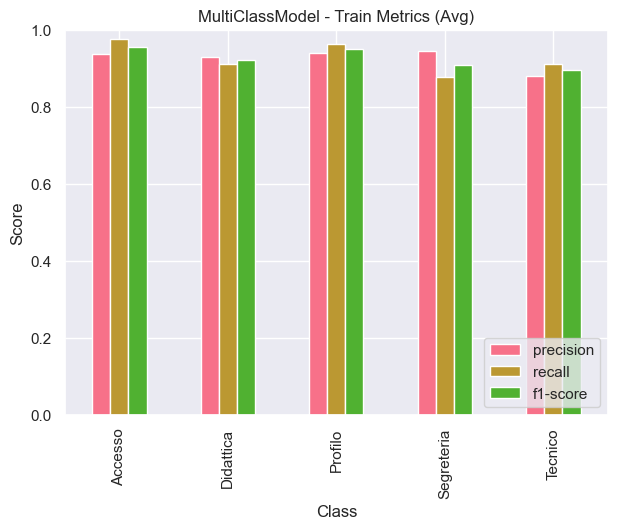

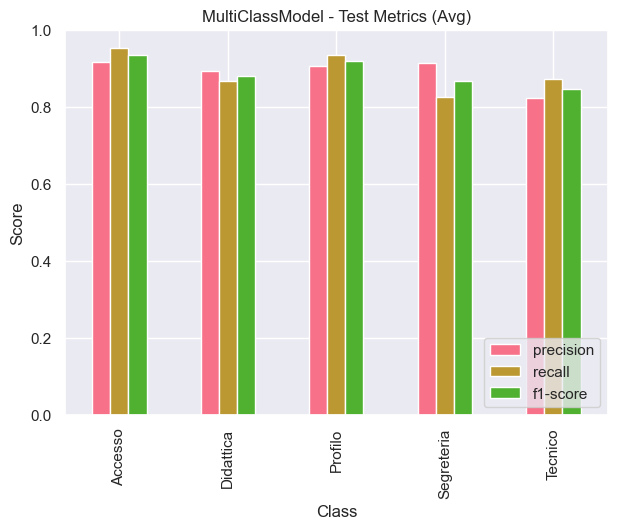

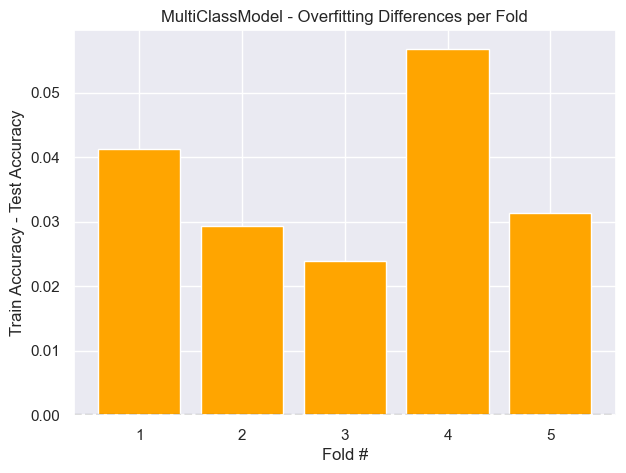

{'train': {'accuracy': 0.92564394608731,
  'confusion_matrix': array([[798.2,   2.4,   6.4,   2.4,   9. ],
         [  3.6, 801.2,   2.4,  29.6,  43.2],
         [ 12.8,   3.2, 770. ,   8.6,   5.4],
         [  7.2,  32.2,  19.4, 777.2,  50.4],
         [ 30.6,  21.8,  20.6,   5.2, 792.2]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.936436  0.975319  0.955471   818.400000
  Didattica      0.930767  0.910455  0.920497   880.000000
  Profilo        0.940423  0.962500  0.951321   800.000000
  Segreteria     0.944363  0.876808  0.909307   886.400000
  Tecnico        0.880047  0.910157  0.894843   870.400000
  accuracy       0.925644  0.925644  0.925644     0.925644
  macro avg      0.926407  0.927048  0.926288  4255.200000
  weighted avg   0.926131  0.925644  0.925440  4255.200000},
 'test': {'accuracy': 0.8890777626097227,
  'confusion_matrix': array([[195. ,   1.2,   3.4,   0.8,   4.2],
         [  0.8, 190.6,   1.6,  11.2,  15.8],
       

In [39]:
from service.report_predict import evaluate_model_with_kfold
from service.pipeline import measure_pc_metrics_during_training
measure_pc_metrics_during_training(ClassifierType.NAIVE_BAYES, save_plot=False)
evaluate_model_with_kfold(get_model(ClassifierType.NAIVE_BAYES), X_processed, y)

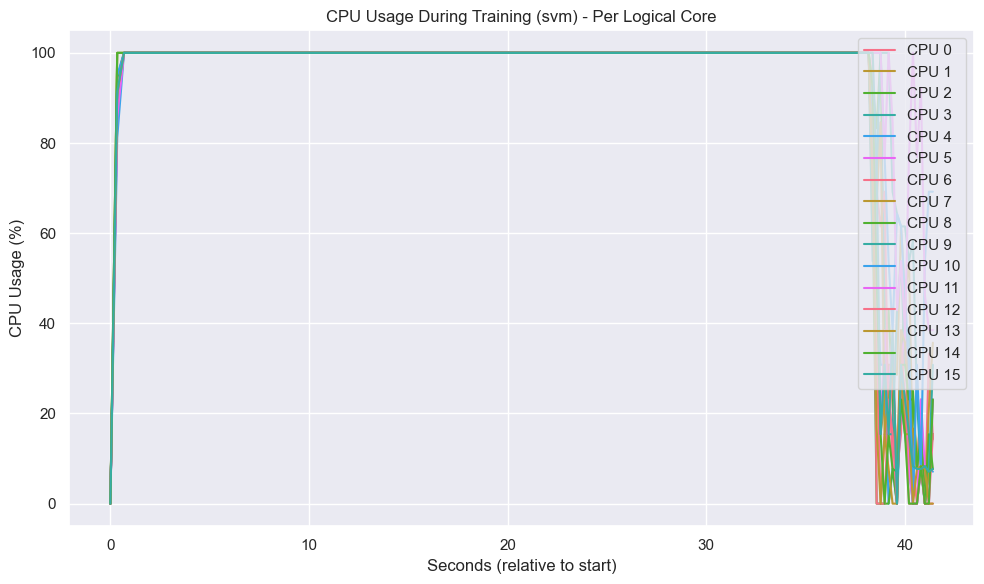

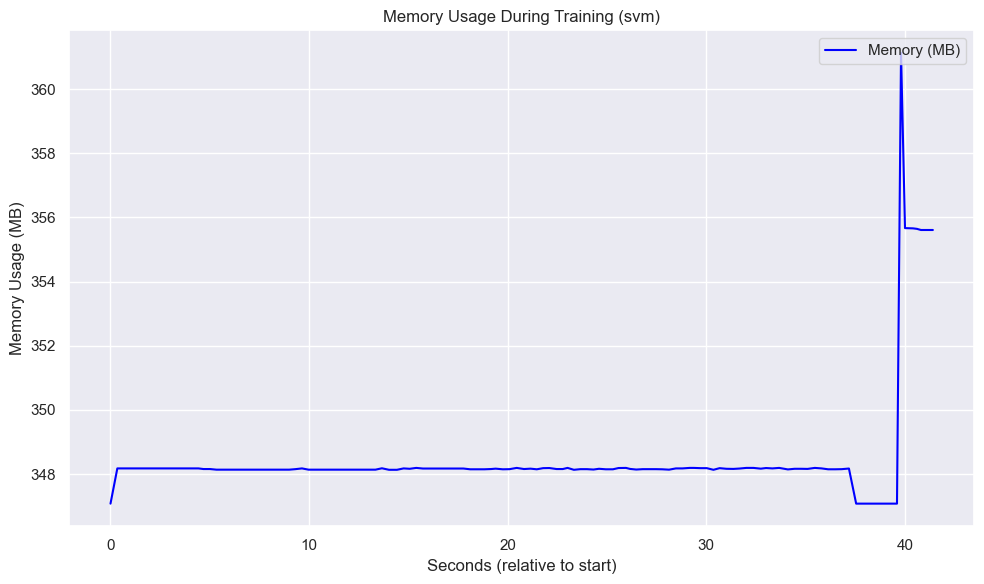

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000, min_df=3,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('svd', TruncatedSVD(n_components=100, random_state=42)),
                ('clf',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [40]:
measure_pc_metrics_during_training(ClassifierType.SVM, save_plot=False)

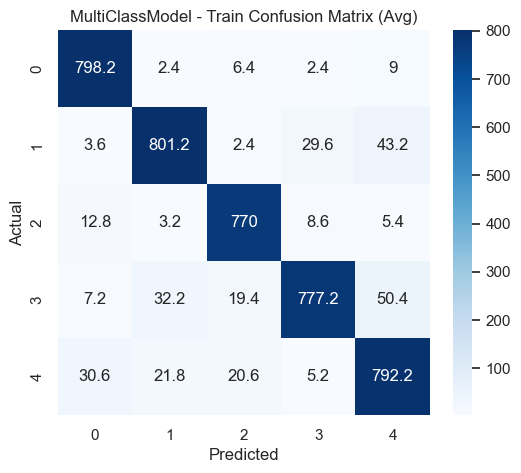

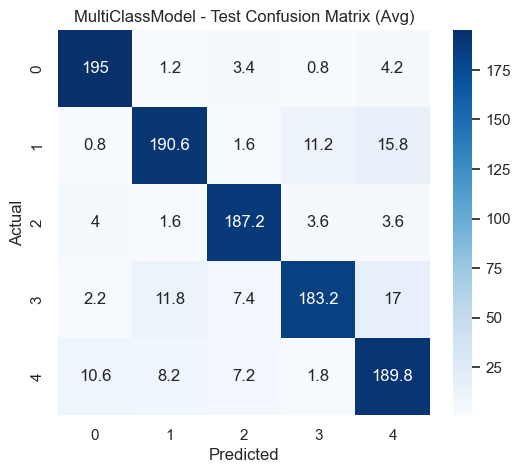

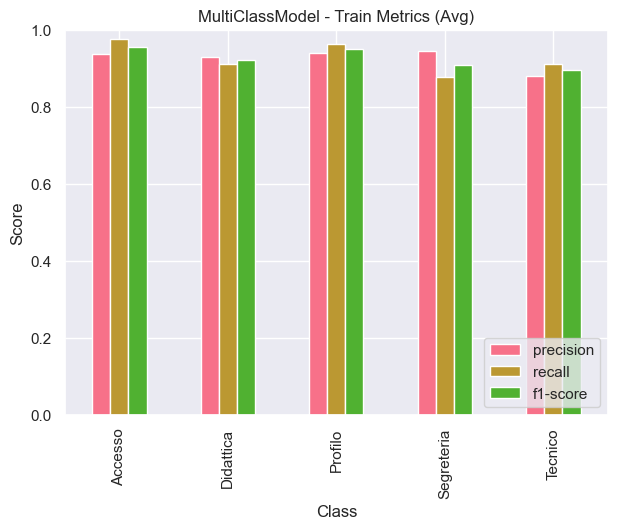

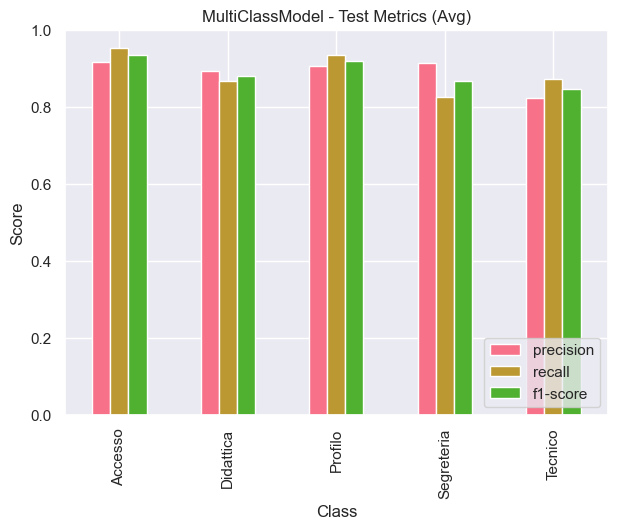

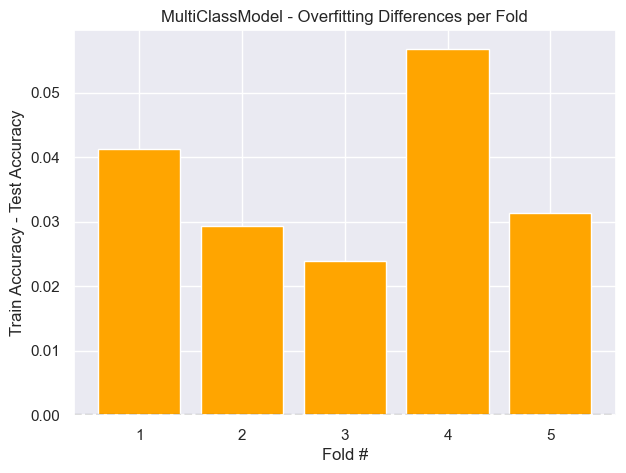

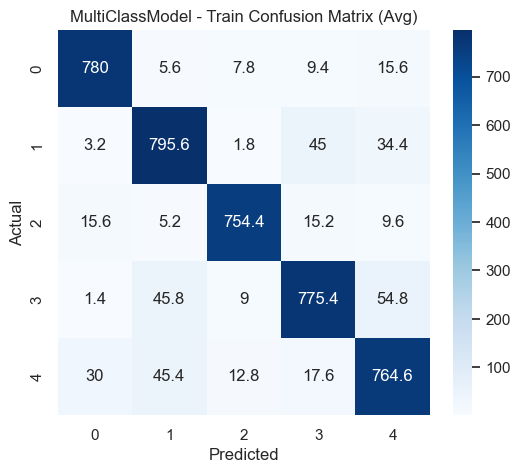

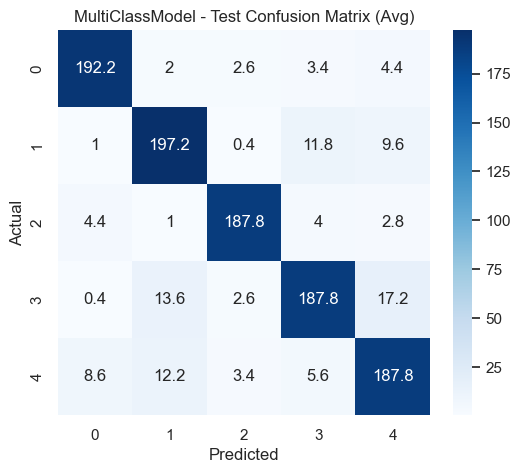

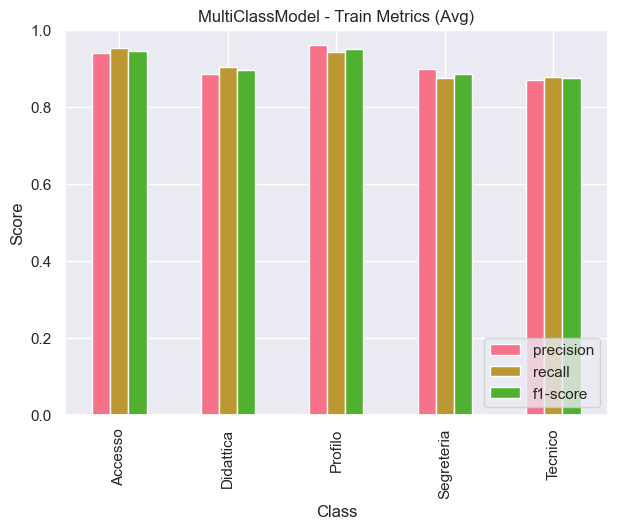

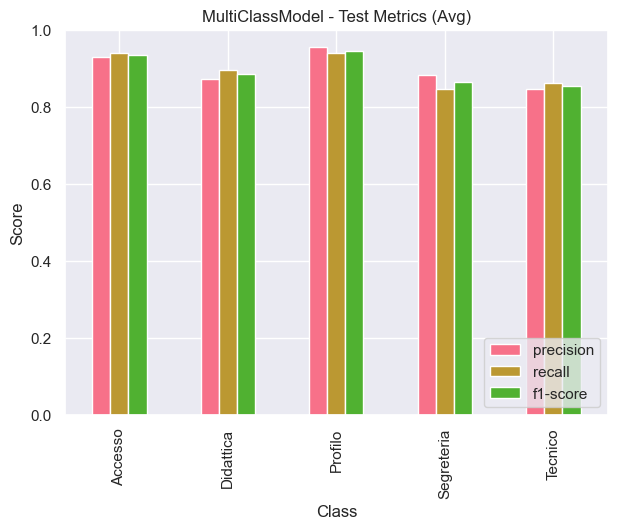

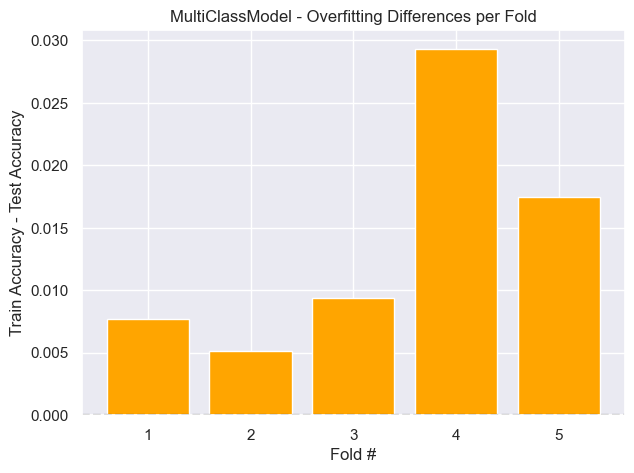

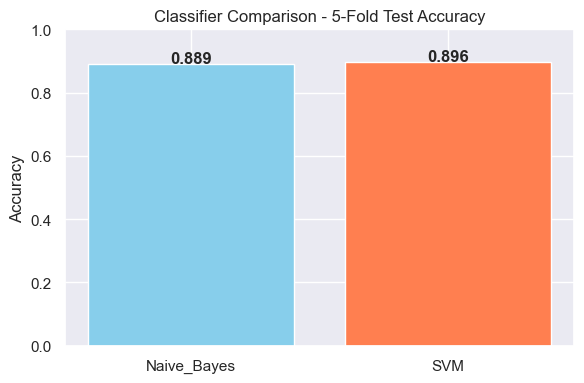

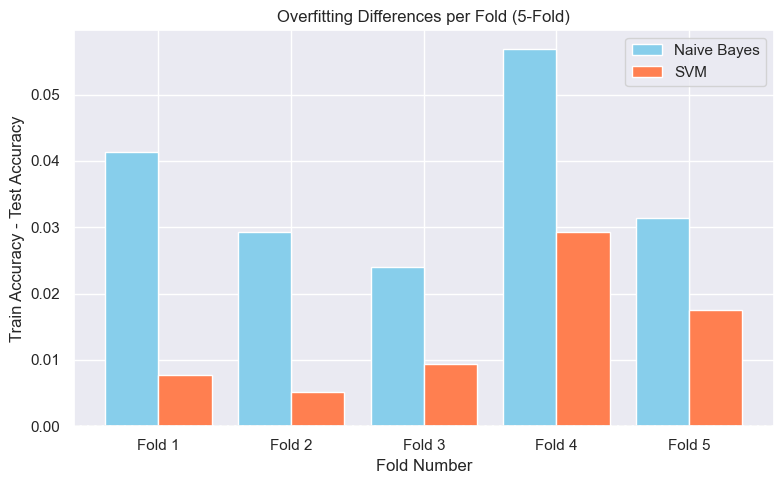

Comparison Results (Naive Bayes vs. SVM):


' Classifier  Train Accuracy  Test Accuracy Train AUC Test AUC  Overfitting (Train-Test)\nNaive_Bayes        0.925644       0.889078       N/A      N/A                  0.036566\n        SVM        0.909476       0.895656       N/A      N/A                  0.013819'

In [41]:
from service.report_predict import compare_classifiers_with_kfold

# Example usage of compare_classifiers_with_kfold
logger.info("Starting K-Fold comparison of Naive Bayes vs. SVM...")

# Use the entire preprocessed dataset
X_small, y_small = X_processed, y

# Compare the two classifiers with 5-fold CV,
# saving both the plots and the resulting DataFrame.
df_results = compare_classifiers_with_kfold(
    X_small,
    y_small,
    n_splits=5,
    shuffle=True,
    random_state=42,
    save_plots=False,  # True -> saves bar charts + mean ROC
    save_data=False  # True -> saves the final df_compare to CSV
)

print("Comparison Results (Naive Bayes vs. SVM):")
df_results.to_string(index=False)

## Esempio di utilizzo con SVM

In [42]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.SVM), columns=["Class", "Probability"])

Predizioni: [('Tecnico', np.float64(0.9767640877358327)), ('Segreteria', np.float64(0.010292631181169883)), ('Accesso', np.float64(0.007864977492680504))]


,Class,Probability
0,Tecnico,0.976764
1,Segreteria,0.010293
2,Accesso,0.007865


## Esempio di utilizzo con NAIVE BAYES

In [43]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES), columns=["Class", "Probability"])

Predizioni: [(np.str_('Tecnico'), np.float64(0.8102093960831581)), (np.str_('Accesso'), np.float64(0.07735695816323566)), (np.str_('Didattica'), np.float64(0.04042343314393931))]


,Class,Probability
0,Tecnico,0.810209
1,Accesso,0.077357
2,Didattica,0.040423
